In [ ]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
!pip install keras-tqdm

In [ ]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df.head()
df = df.dropna()

In [ ]:
n_timesteps = 200
n_features = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - n_timesteps, step):
  x_segment = df['x-axis'].values[i: i + n_timesteps]
  y_segment = df['y-axis'].values[i: i + n_timesteps]
  z_segment = df['z-axis'].values[i: i + n_timesteps]
  label = stats.mode(df['activity'][i: i + n_timesteps])[0][0]
  segments.append([x_segment, y_segment, z_segment])
  labels.append(label)
  

In [ ]:
#input is in the format [samples, features, timesteps]
np.array(segments).shape

(54901, 3, 200)

In [ ]:
# reshaping the input segment into the format [samples, timesteps, features]
reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, n_timesteps, n_features)

In [ ]:
reshaped_segments.shape

(54901, 200, 3)

In [ ]:
# Applying one-hot encoding to the activity field
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
#Splitting the input data into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.25)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
# Building the Model
from keras import regularizers
epochs = 50
batch_size = 1024

model = Sequential()
model.add(LSTM(64, input_shape = (n_timesteps, n_features), return_sequences = True, name = 'input'))
model.add(Dropout(rate = 0.5))
model.add(LSTM(64,return_sequences = False))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(6, activation = 'softmax', kernel_regularizer = regularizers.l2(0.0015), name = 'output'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# Compiling the Model
from keras import optimizers

adam = keras.optimizers.Adam(lr = 0.0025, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [ ]:
from keras_tqdm import TQDMNotebookCallback
har_model = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, y_test), verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 41175 samples, validate on 13726 samples
Epoch 1/50





41175/41175 [==============================] - 47s 1ms/step - loss: 1.0117 - acc: 0.6376 - val_loss: 0.6507 - val_acc: 0.7772
Epoch 2/50
41175/41175 [==============================] - 42s 1ms/step - loss: 0.5717 - acc: 0.8011 - val_loss: 0.5736 - val_acc: 0.7980
Epoch 3/50
41175/41175 [==============================] - 41s 1ms/step - loss: 0.4944 - acc: 0.8245 - val_loss: 0.4636 - val_acc: 0.8264
Epoch 4/50
41175/41175 [==============================] - 42s 1ms/step - loss: 0.4387 - acc: 0.8410 - val_loss: 0.4451 - val_acc: 0.8458
Epoch 5/50
41175/41175 [==============================] - 41s 1ms/step - loss: 0.4069 - acc: 0.8513 - val_loss: 0.3764 - val_acc: 0.8571
Epoch 6/50
41175/41175 [==============================] - 42s 1ms/step - loss: 0.3627 - acc: 0.8652 - val_loss: 0.3604 - val_acc: 0.8649
Epoch 7/50
41175/41175 [==

In [ ]:
from keras.callbacks import History 

train_loss = har_model.history['loss']
val_loss   = har_model.history['val_loss']
train_acc  = har_model.history['acc']
val_acc    = har_model.history['val_acc']
xc         = range(epochs)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (LSTM)                 (None, 200, 64)           17408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
output (Dense)               (None, 6)                 606       
Total params: 57,538
Trainable params: 57,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
[node.op.name for node in model.outputs]

['output/Softmax']

In [ ]:
session = keras.backend.get_session()

In [ ]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
min_graph = convert_variables_to_constants(session, session.graph_def, [node.op.name for node in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [ ]:
import tensorflow
tensorflow.train.write_graph(min_graph, "content/", "har.pb", as_text=False)

'content/har.pb'

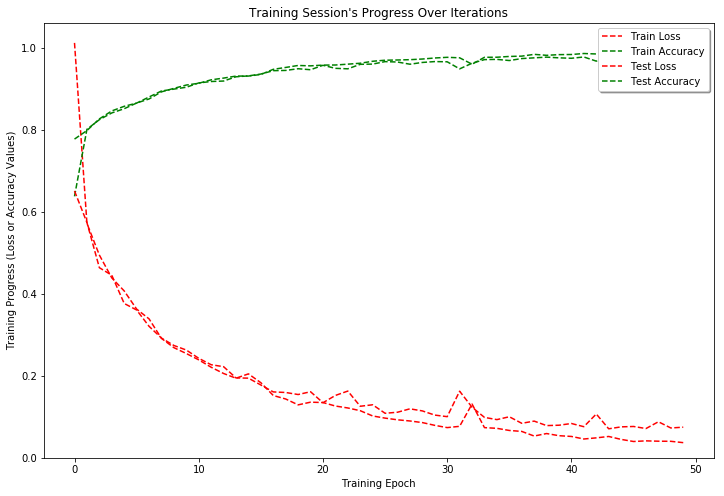

In [ ]:
plt.figure(figsize = (12,8))

plt.plot(np.array(har_model.history['loss']),"r--", label = "Train Loss")
plt.plot(np.array(har_model.history['acc']), "g--", label = "Train Accuracy")
plt.plot(np.array(har_model.history['val_loss']), "r--", label = "Test Loss")
plt.plot(np.array(har_model.history['val_acc']), "g--", label = "Test Accuracy")

plt.title("Training Session's Progress Over Iterations")
plt.legend(loc = 'upper right', shadow = True)
plt.ylabel("Training Progress (Loss or Accuracy Values)")
plt.xlabel("Training Epoch")
plt.ylim(0)

plt.show()

In [ ]:
evals = model.evaluate(X_test, y_test)[1]

13726/13726 [==============================] - 124s 9ms/step


In [ ]:
evals

0.9785807955096557

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

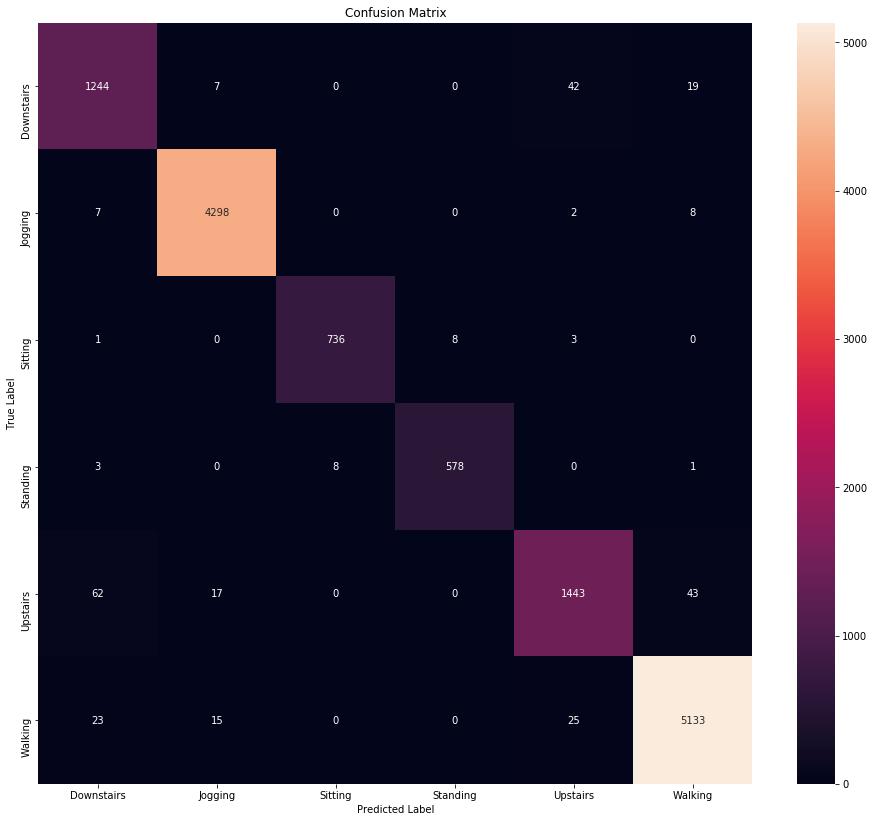

In [ ]:
import seaborn as sns
from sklearn import metrics 

max_test = np.argmax(y_test, axis = 1)
max_predictions = np.argmax(y_pred, axis = 1)
confusion_matrix = metrics.confusion_matrix(max_test,max_predictions)

plt.figure(figsize = (16,14))
sns.heatmap(confusion_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd');
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()